In [1]:
from datetime import datetime, timedelta
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import multiprocessing
import numpy as np
import os
from scipy.ndimage import gaussian_filter, sobel
import xarray as xr



from ormhw.gebco import import_gebco
from ormhw.core import BoundingBox, CE01, CE02, CE04, NH_LINE, CAPE_BLANCO, COLUMBIA_RIVER

In [2]:
years = range(2015,2024)
figsize = (6,5)
dpi = 600
filename = 'nasa_oc'
filetype = 'jpg'
matplotlib.rcParams.update({'font.size': 8})

oc_cmap = matplotlib.colormaps.get_cmap('Greens')
oc_cmap.set_under('white')

In [3]:
oc = xr.open_dataset('/home/jovyan/data/nasa/oc_2015-2023.nc')

In [4]:
bbox = BoundingBox(lat_min = 41, lat_max = 47, lon_min = -126.75, lon_max = -123.75)
gebco = import_gebco(filepath = '/home/jovyan/data/gebco/GEBCO_2023.nc', bounding_box = bbox)
gebco_land = gebco.where(gebco.depth <=0, drop = True)
landx, landy = np.meshgrid(gebco_land.lon, gebco_land.lat)
landz = gebco_land.depth

gebco_cmap = matplotlib.colormaps.get_cmap('Grays')
gebco_cmap.set_under('gray')

CPU times: user 6.35 s, sys: 3.11 s, total: 9.45 s
Wall time: 40 s


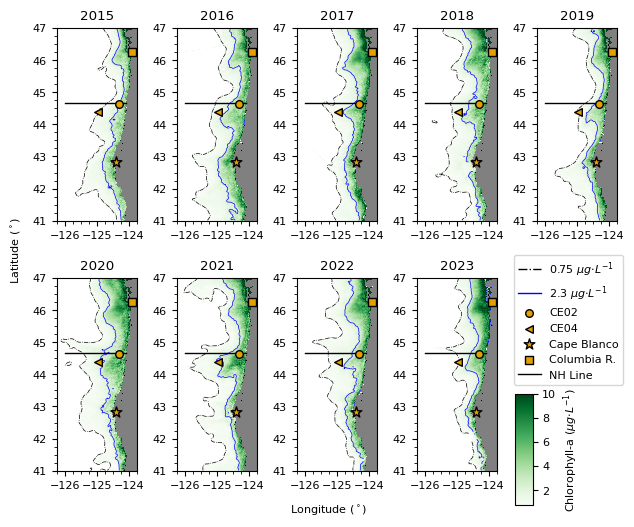

In [5]:
%%time
fig = plt.figure(figsize = figsize, constrained_layout = True)
grid = (2,5)
ax15 = plt.subplot2grid(grid, (0,0), colspan = 1,rowspan = 1)
ax16 = plt.subplot2grid(grid, (0,1), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax17 = plt.subplot2grid(grid, (0,2), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax18 = plt.subplot2grid(grid, (0,3), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax19 = plt.subplot2grid(grid, (0,4), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax20 = plt.subplot2grid(grid, (1,0), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax21 = plt.subplot2grid(grid, (1,1), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax22 = plt.subplot2grid(grid, (1,2), colspan = 1,rowspan = 1, sharex=ax15, sharey=ax15)
ax23 = plt.subplot2grid(grid, (1,3), colspan = 1, rowspan = 1, sharex=ax15, sharey=ax15)
axs = [ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22,ax23]

for year in years:
    idx = years.index(year)
    ax = axs[idx]
    ax.set_facecolor('gray')
    
    _oc = oc.sel(time = slice(datetime(year,7,9),datetime(year,10,8,23,59,59)),latitude = slice(41,47), longitude = slice(-126.25, -123.75))
    _oc = _oc.mean(dim = 'time')
    _ocx, _ocy = np.meshgrid(_oc.longitude, _oc.latitude)
    _ocz = _oc.chl
    
    ocp = ax.pcolormesh(_ocx, _ocy, _ocz, cmap = oc_cmap, vmin = 0.75, vmax = 10, zorder = 0)


    filt1 = gaussian_filter(_ocz, sigma = 4.5)
    ax.contour(_ocx,_ocy,filt1, levels = [0.75], colors = 'black', zorder = 1, linewidths = 0.5, linestyles = 'dashdot')

    filt2 = gaussian_filter(_ocz, sigma = 1.5)
    ax.contour(_ocx,_ocy,filt2, levels = [2.3], colors = 'blue', zorder = 1, linewidths = 0.5)

    
    ax.set_ylim(41,47)
    ax.set_xlim(-126.25,-123.75)
    ax.set_box_aspect((47-41)/(-123.75 + 126.25))
    ax.set_title(year)

    
    ax.pcolormesh(landx, landy, landz, cmap = gebco_cmap, zorder = 2, vmin = -0.0000000001, vmax =0)
    
    
    ax.scatter(CE02.lon, CE02.lat, s = 30, color = (230/255,159/255,0/255), marker = 'o',edgecolors = 'black', zorder = 3, linewidth = 1)
    ax.scatter(CE04.lon, CE04.lat, s = 30, color = (230/255,159/255,0/255), marker = '<',edgecolors = 'black', zorder = 3 ,linewidth = 1)
    ax.scatter(CAPE_BLANCO.lon, CAPE_BLANCO.lat, s = 65, color = (230/255,159/255,0/255), marker = '*',edgecolors = 'black', zorder = 3,linewidth = 1)
    ax.scatter(COLUMBIA_RIVER.lon, COLUMBIA_RIVER.lat, s = 35, color = (230/255,159/255,0/255), marker = 's',edgecolors = 'black', zorder = 3,linewidth = 1)
    ax.plot([NH_LINE.lon_min,NH_LINE.lon_max],[NH_LINE.lat,NH_LINE.lat],color = 'black', zorder = 2,linewidth = 1, linestyle = '-')

    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
    
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.25))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))

fig.text(0.5, -0.02, r'Longitude ($^\circ$)' , ha='center', va='center')
fig.text(-0.02, 0.5, r'Latitude ($^\circ$)', ha='center', va='center', rotation='vertical')

ax.plot([],[],color = 'black', zorder = 2,linewidth = 1, linestyle = 'dashdot', label = r'0.75 ${\mu}g{\cdot}L^{-1}$')
ax.plot([],[],color = 'blue', zorder = 2,linewidth = 1, linestyle = '-', label =  r'2.3 ${\mu}g{\cdot}L^{-1}$')
ax.scatter([],[], s = 30, color = (230/255,159/255,0/255), marker = 'o',edgecolors = 'black', zorder = 3, linewidth = 1, label = 'CE02')
ax.scatter([],[], s = 30, color = (230/255,159/255,0/255), marker = '<',edgecolors = 'black', zorder = 3 ,linewidth = 1, label = 'CE04')
ax.scatter([],[], s = 65, color = (230/255,159/255,0/255), marker = '*',edgecolors = 'black', zorder = 3,linewidth = 1, label = 'Cape Blanco')
ax.scatter([],[], s = 35, color = (230/255,159/255,0/255), marker = 's',edgecolors = 'black', zorder = 3,linewidth = 1,label = 'Columbia R.')
ax.plot([],[],color = 'black', zorder = 2,linewidth = 1, linestyle = '-', label = 'NH Line')


fig.legend( ncol = 1, loc = (0.81,0.27))
cbar_ax = fig.add_axes([0.81, -0.01, 0.03, 0.2225])
cbar = fig.colorbar(ocp, cax=cbar_ax,label = r'Chlorophyll-a (${\mu}g{\cdot}L^{-1}$)')   #, $\frac{MHW\ Days}{Total\ Days}$)
plt.savefig(f'/home/jovyan/oregon-shelf-mhw/figures/{filename}.{filetype}', dpi = dpi,bbox_inches='tight', pad_inches=0.1)
